In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
infile = '~/Desktop/mid_market_measurement/data/turn_board/Turn_Board_Active_Usage_2021_05_12.csv'


In [3]:
df = pd.read_csv(infile)

In [13]:
df.columns

Index(['CUSTOMER_SEGMENT', 'VHOST', 'PROPERTY_ID', 'UNIT_GROUP_ID', 'UNIT_ID',
       'UNIT_UUID', 'OCCUPANCY_ID', 'MOVE_OUT_DATE', 'MOVE_OUT_OCCUPANCY_ID',
       'TURN_ID', 'ACTIVE_USER_USAGE_TIMESTAMP', 'TOTAL_INTERACTIONS',
       'LAST_UPDATED_AT', 'LAST_UPDATED_DATE'],
      dtype='object')

In [166]:
df['MOVE_OUT_DATE'] = pd.to_datetime(df['MOVE_OUT_DATE'])
df['LAST_UPDATED_DATE'] = pd.to_datetime(df['LAST_UPDATED_AT']).dt.date
df['LAST_UPDATED_AT'] = pd.to_datetime(df['LAST_UPDATED_AT'])
df['TOTAL_INTERACTIONS'].fillna(0, inplace=True)

In [15]:
df['UNIQUE_PROPERTIES'] = df['VHOST'] +'-'+ df['PROPERTY_ID'].astype(str)
df['UNIQUE_UNITS'] = df['VHOST'].astype(str) +'-'+ df['PROPERTY_ID'].astype(str) + '-' + df['UNIT_ID'].astype(str)

In [47]:
df[['VHOST', 'OCCUPANCY_ID', 'MOVE_OUT_DATE', 'TURN_ID', 'TOTAL_INTERACTIONS']].sort_values(by='MOVE_OUT_DATE', ascending=False)

# df.groupby('LAST_UPDATED_DATE').agg(['sum','count'])['TOTAL_INTERACTIONS'].plot()
# df.groupby(['LAST_UPDATED_DATE', 'UNIQUE_PROPERTIES']).sum()['TOTAL_INTERACTIONS']
# df.groupby('LAST_UPDATED_DATE').agg({'TOTAL_INTERACTIONS': ['sum', 'count']}.plot(title='Active Turn Board Use', ylabel='Meaningful Interactions')

,VHOST,OCCUPANCY_ID,MOVE_OUT_DATE,TURN_ID,TOTAL_INTERACTIONS
358168,dougwettonproperties,14097,2021-05-12,751.0,NaN
124040,empirerem,301,2021-05-12,NaN,NaN
375578,utopiamanagement,34396,2021-05-12,1189.0,NaN
324627,scottoneill,261,2021-05-12,NaN,NaN
315747,bayshoreproperties,11305,2021-05-12,NaN,NaN
...,...,...,...,...,...
293028,networkrealestate,372,2021-02-03,NaN,NaN
213559,trgrealty,1155,2021-02-03,NaN,NaN
293008,marshallreddick,3793,2021-02-03,222.0,NaN
50936,amj,1571,2021-02-03,NaN,NaN


In [39]:
def active_users_by_cohort(interactions_log_df, period_length=1, user_column='VHOST', independent_variable_col='MOVE_OUT_DATE'):
    active_user_df = pd.DataFrame({"date": pd.date_range(interactions_log_df['MOVE_OUT_DATE'].min(), interactions_log_df['MOVE_OUT_DATE'].max())})
    active_user_count_df = pd.DataFrame({"date": pd.date_range(interactions_log_df['MOVE_OUT_DATE'].min(), interactions_log_df['MOVE_OUT_DATE'].max())})
    existing_users = set()
    for cohort_date in trange(len(active_user_df)):
        active_user_df[cohort_date] = np.nan
        active_user_count_df[cohort_date] = 0
        origin_date = active_user_df[independent_variable_col][cohort_date]
        offset_date = origin_date - pd.offsets.Day(int(period_length))
        base_cohort = set(interactions_log_df[
                              (interactions_log_df[independent_variable_col] <= origin_date) &
                              (interactions_log_df[independent_variable_col] > offset_date)
                          ][user_column].unique()) - existing_users
        existing_users.update(base_cohort)
        for i in range(cohort_date, len(active_user_df)):
            origin_date = active_user_df[independent_variable_col][i]
            offset_date = origin_date - pd.offsets.Day(int(period_length))
            current_cohort = set(interactions_log_df[
                                     (interactions_log_df[independent_variable_col] <= origin_date) &
                                     (interactions_log_df[independent_variable_col] > offset_date)
                                 ][user_column].unique())
            if len(base_cohort) != 0:
                active_user_df.loc[i, cohort_date] = len(base_cohort & current_cohort)/len(base_cohort)
                active_user_count_df.loc[i, cohort_date] = len(base_cohort & current_cohort)
    return active_user_df, active_user_count_df

In [119]:
this = df[df['VHOST'] == 'birgo'].groupby(['VHOST', 'OCCUPANCY_ID']).count()[['TURN_ID', 'TOTAL_INTERACTIONS']].eval('USAGE_RATE = TOTAL_INTERACTIONS / TURN_ID')
    # jevonsproperty
    # northoakprop
    # birgo

    # .agg({'OCCUPANCY_ID': 'count', 'TURN_ID':'count', 'TOTAL_INTERACTIONS': 'count', })

In [130]:
this = this.reset_index()
this = this[
    (this.OCCUPANCY_ID > 0) &
    (this.TURN_ID > 0)
].reset_index()
this['SEQUENCE_ID'] = np.nan
# this

ValueError: cannot insert level_0, already exists

In [131]:
first_active = this[(this.TOTAL_INTERACTIONS > 0)].index[0]
this.loc[this[first_active:].index, 'SEQUENCE_ID'] = range(0, len(this) - first_active)
# this.loc[this[(this.TOTAL_INTERACTIONS > 0)].index[0]:]['SEQUENCE_ID'] = range(0, len(this[this[(this.TOTAL_INTERACTIONS > 0)].index[0]:]))
# this.loc[this[3:].index, 'SEQUENCE_ID'] = range(0, 40)

# this.loc[(this.index >= start_range), 'SEQUENCE_ID'] =
# this[(this.TOTAL_INTERACTIONS > 0)].index[0]
# ge(0, len(this) - start_range - 1)
# this
# pd.date_range(this.reset_index()['MOVE_OUT_DATE'].min(), this.reset_index()['MOVE_OUT_DATE'].max()).sort_values()

In [225]:
session_df = pd.DataFrame({'session' : range(0, df.groupby(['VHOST']).size().max())})
for vhost in df[df.TOTAL_INTERACTIONS != 0]['VHOST'].unique():
    session_df[vhost] = np.nan
    temp_df = df[
        (df.VHOST == vhost) &
        (df.TURN_ID.notnull())
    ].reset_index()
    temp_df['SESSION_ID'] = np.nan
    first_active = temp_df[temp_df.TOTAL_INTERACTIONS > 0].index[0]
    temp_df.loc[temp_df[first_active:].index, 'SESSION_ID'] = range(0, len(temp_df) - first_active)
    for id in temp_df[temp_df.SESSION_ID.notnull()]['SESSION_ID']:
        session_df.loc[id, vhost] = min(temp_df[(temp_df.SESSION_ID == id)]['TOTAL_INTERACTIONS'].max(), 1)


session_df

,session,encoremgmt,reedypropertygroup,youngamericarealty,fox,nestmanagement,steinerrealty,daymarkinc,kellernjadd,leuvengroup,...,pegasusmgt,norpointcommunities,progressivesf,vegashomes4rent,wspropmgmt,sermar,sixstarproperties,garciagrp,utopiamanagement,thosdwalsh
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,4438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4439,4439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4440,4440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4441,4441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


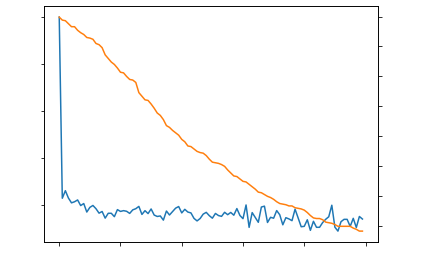

In [262]:
# df.groupby(['VHOST']).count()['TURN_ID'].mean() # average is 10
# session_df.iloc[:,1:].mean(axis=1)[:50].plot()
# session_df.iloc[:,1:].count(axis=1)[:100].plot()
obs = 100
cnt_occupancies = session_df.iloc[:,1:].count(axis=1)[:obs]
avg_rentention = session_df.iloc[:,1:].mean(axis=1)[:obs]

fig, ax1 = plt.subplots()
color = 'tab:blue'
text_color = 'white'
ax1.set_xlabel('nth occupancy after first meaningful turn board interaction', color=text_color)
ax1.set_ylabel('avg retention', color=text_color)
ax1.plot(avg_rentention, color=color)
ax1.tick_params(axis='y', labelcolor=text_color)
ax1.tick_params(axis='x', labelcolor=text_color)

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('occupancies', color=text_color)
ax2.plot(cnt_occupancies, color=color)
ax2.tick_params(axis='y', labelcolor=text_color)

fig.tight_layout()
plt.show()